In [1]:
!pip install matplotlib

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
# Define the directory where the images are located
directory = '../datasets/image_classifier/dataset1/known_images'

# Get a list of all the image files in the directory
image_files = os.listdir(directory)

# Define the target image size
image_size = (420, 420)

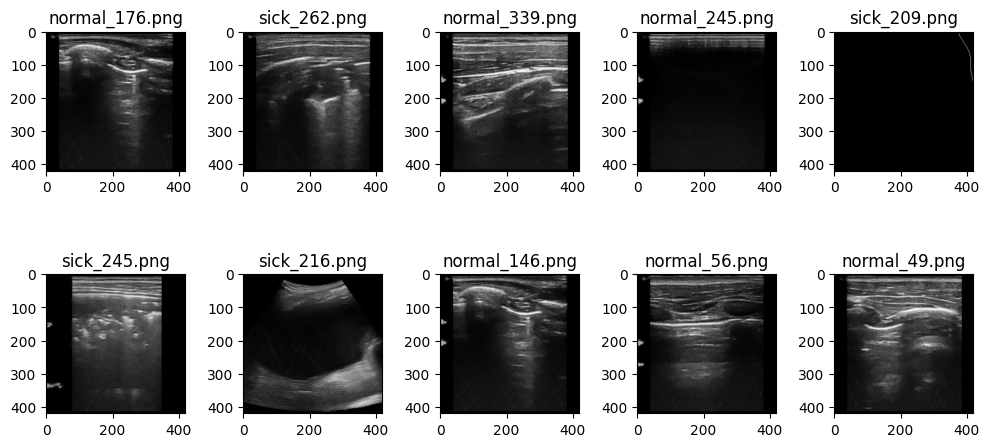

In [4]:
# Plot some example images from the dataset
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    img = cv2.imread(os.path.join(directory, image_files[i]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    ax.imshow(img)
    ax.set_title(image_files[i])
plt.tight_layout()
plt.show()

In [6]:
!pip install pandas
!pip install scikit-learn

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

# generate list of corresponding classes using list comprehension
classes = ["normal" if "normal" in name else "sick" for name in image_files]

# create a dataframe with image names and classes
data = pd.DataFrame({"filename": image_files, "class": classes})

# save the dataframe as a csv file
data.to_csv("data1.csv", index=False)

# partition the data into training and validation sets
train_data, test_and_valid_data = train_test_split(data, test_size=0.2, random_state=42)
valid_data, test_data = train_test_split(test_and_valid_data, test_size=0.5, random_state=42)

# print number of images in training and validation sets
print("Training images:", len(train_data))
print("Validation images:", len(valid_data))
print("Test images:", len(test_data))

Training images: 572
Validation images: 71
Test images: 72


In [8]:
data.head(10)

,filename,class
0,normal_176.png,normal
1,sick_262.png,sick
2,normal_339.png,normal
3,normal_245.png,normal
4,sick_209.png,sick
5,sick_245.png,sick
6,sick_216.png,sick
7,normal_146.png,normal
8,normal_56.png,normal
9,normal_49.png,normal


In [10]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create ImageDataGenerator without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size and image size
batch_size = 32
image_size = (420, 420)

# Create generators from DataFrames
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory=directory,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory=directory,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

valid_generator = test_datagen.flow_from_dataframe(
    valid_data,
    directory=directory,
    x_col='filename',
    y_col='class',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 572 validated image filenames belonging to 2 classes.
Found 72 validated image filenames belonging to 2 classes.
Found 71 validated image filenames belonging to 2 classes.


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(420, 420, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.summary()

2023-05-25 14:05:36.945705: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 418, 418, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 209, 209, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 207, 207, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 103, 103, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 101, 101, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 128)      0

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory to save the model weights
checkpoint_path = "model_checkpoints/best_model.hdf5"

# Create a ModelCheckpoint callback to save the best model weights
checkpoint_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min', 
    verbose=1
)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 50

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[checkpoint_callback]
)

2023-05-25 14:09:18.158151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 1.0091 - accuracy: 0.6049

2023-05-25 14:10:38.389973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.64660, saving model to model_checkpoints/best_model.hdf5
18/18 [==============================] - 83s 4s/step - loss: 1.0091 - accuracy: 0.6049 - val_loss: 0.6466 - val_accuracy: 0.5634
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.5817 - accuracy: 0.7168
Epoch 2: val_loss improved from 0.64660 to 0.53763, saving model to model_checkpoints/best_model.hdf5
18/18 [==============================] - 107s 6s/step - loss: 0.5817 - accuracy: 0.7168 - val_loss: 0.5376 - val_accuracy: 0.7042
Epoch 3/50
18/18 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7797
Epoch 3: val_loss improved from 0.53763 to 0.42315, saving model to model_checkpoints/best_model.hdf5
18/18 [==============================] - 89s 5s/step - loss: 0.5164 - accuracy: 0.7797 - val_loss: 0.4231 - val_accuracy: 0.7887
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.4394 - accuracy: 0.7937
Epoch 4: val_loss did not i

18/18 [==============================] - 78s 4s/step - loss: 0.1820 - accuracy: 0.9213 - val_loss: 0.1632 - val_accuracy: 0.9155
Epoch 30/50
18/18 [==============================] - ETA: 0s - loss: 0.1692 - accuracy: 0.9213
Epoch 30: val_loss did not improve from 0.12819
18/18 [==============================] - 83s 5s/step - loss: 0.1692 - accuracy: 0.9213 - val_loss: 0.1431 - val_accuracy: 0.9437
Epoch 31/50
18/18 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9441
Epoch 31: val_loss did not improve from 0.12819
18/18 [==============================] - 85s 5s/step - loss: 0.1426 - accuracy: 0.9441 - val_loss: 0.1531 - val_accuracy: 0.9155
Epoch 32/50
18/18 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.9388
Epoch 32: val_loss did not improve from 0.12819
18/18 [==============================] - 80s 4s/step - loss: 0.1616 - accuracy: 0.9388 - val_loss: 0.2025 - val_accuracy: 0.9437
Epoch 33/50
18/18 [==============================] - ET

In [14]:
model.save("trained_model.h5")

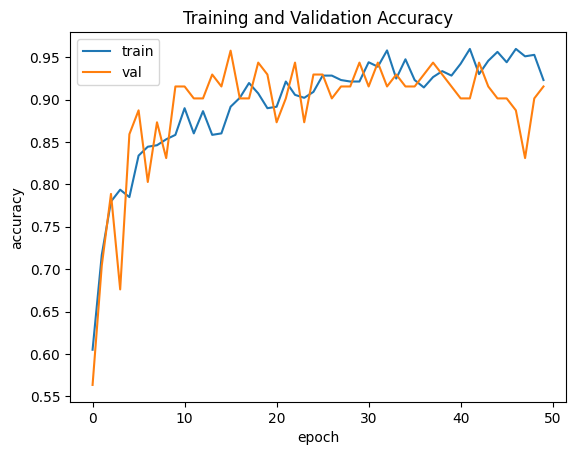

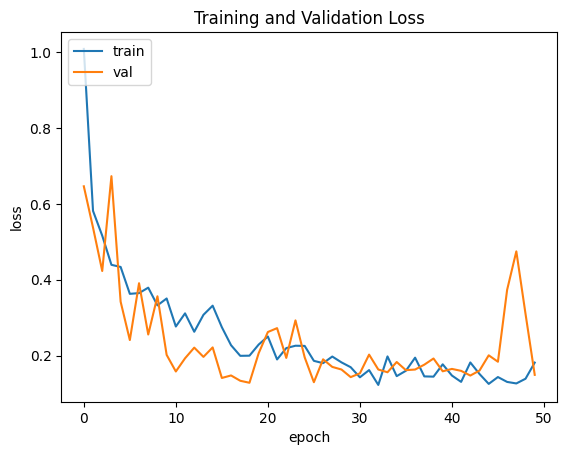

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from tensorflow.keras.models import load_model

# Load the best saved model architecture
model = load_model(checkpoint_path)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

2023-05-25 15:44:14.287622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 2s 332ms/step - loss: 0.1176 - accuracy: 0.9861
Test loss: 0.11756695806980133
Test accuracy: 0.9861111044883728


2023-05-25 15:45:37.260381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 1s 293ms/step


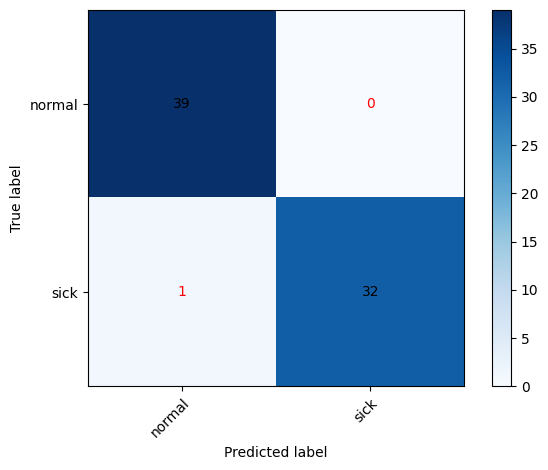

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Define the classes
classes = ['normal', 'sick']

# Get the true labels from the test generator
y_true = test_generator.classes

# Use the model to make predictions on the test set
y_pred = model.predict(test_generator)

# Convert the predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# Set the classes as labels on the x and y axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')
# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over the data and add the count values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > cm.max() / 2. else "red")
fig.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_labels)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        39
           1       1.00      0.97      0.98        33

    accuracy                           0.99        72
   macro avg       0.99      0.98      0.99        72
weighted avg       0.99      0.99      0.99        72



In [54]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Define the directory where the unlabelled images are located
image_dir = '../datasets/image_classifier/dataset1/unknown_images/'

predictions = []
image_names = []

# Loop through all the image files in the directory
for file_name in os.listdir(image_dir):
    # Load the image
    image_path = os.path.join(image_dir, file_name)
    image = load_img(image_path, target_size=(420, 420))

    # Convert the image to a numpy array
    image_array = img_to_array(image)

    # Rescale the pixel values
    image_array = image_array / 255.0

    # Add a batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    
    new_img_array = test_datagen.flow(image_array, batch_size=1)[0]

    # Use the trained model to predict the class of the image
    prediction = model.predict(new_img_array)
    
    # convert predictions to categorical class labels
    class_index = np.argmax(prediction)
    class_label = classes[class_index]
    
    image_names.append(file_name) 
    predictions.append((class_label, file_name))
    print(f"{file_name} - {class_label}")

1/1 [==============================] - 0s 44ms/step
38.png - sick
1/1 [==============================] - 0s 37ms/step
34.png - sick
1/1 [==============================] - 0s 48ms/step
5.png - sick
1/1 [==============================] - 0s 78ms/step
49.png - sick
1/1 [==============================] - 0s 58ms/step
31.png - sick
1/1 [==============================] - 0s 80ms/step
17.png - sick
1/1 [==============================] - 0s 75ms/step
11.png - sick
1/1 [==============================] - 0s 68ms/step
3.png - sick
1/1 [==============================] - 0s 68ms/step
6.png - sick
1/1 [==============================] - 0s 67ms/step
29.png - sick
1/1 [==============================] - 0s 74ms/step
14.png - sick
1/1 [==============================] - 0s 78ms/step
30.png - sick
1/1 [==============================] - 0s 72ms/step
25.png - sick
1/1 [==============================] - 0s 88ms/step
32.png - sick
1/1 [==============================] - 0s 91ms/step
39.png - sick
1/1 [========

In [55]:
import csv

# Save the predictions to a CSV file
with open('unlabelled_predictions.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Label", "Filename"])
    for prediction in predictions:
        writer.writerow(prediction)

In [38]:
# Import the necessary libraries and define the images and csv directory
import pandas as pd
import os

directory = '../datasets/image_classifier/dataset2/images/'
image_files = os.listdir(directory)

labels_df = pd.read_csv('../datasets/image_classifier/dataset2/image_classes.csv')

In [39]:
# Merge the two dataframes on the patient column
image_data = pd.DataFrame({'filename': image_files})
image_data['patient'] = image_data['filename'].apply(lambda x: os.path.splitext(x)[0])
image_data = pd.merge(image_data, labels_df, on='patient')

# Display the first few rows of the resulting dataframe
print(image_data.head())

          filename      patient  diagnosis
0  sick_eif102.png  sick_eif102          1
1  sick_eif111.png  sick_eif111          1
2   sick_eif55.png   sick_eif55          1
3  sick_eif104.png  sick_eif104          1
4   sick_eff23.png   sick_eff23          0


In [40]:
# Drop the patient column
image_data = image_data.drop(columns=['patient'])

print(image_data.head(5))

          filename  diagnosis
0  sick_eif102.png          1
1  sick_eif111.png          1
2   sick_eif55.png          1
3  sick_eif104.png          1
4   sick_eff23.png          0


In [46]:
# Define a dictionary mapping the values
label_mapping = {1: 'sick', 0: 'normal'}

# Use the map() function to convert the values
image_data['diagnosis'] = image_data['diagnosis'].map(label_mapping)
print(image_data.head(5))

          filename diagnosis
0  sick_eif102.png      sick
1  sick_eif111.png      sick
2   sick_eif55.png      sick
3  sick_eif104.png      sick
4   sick_eff23.png    normal


In [47]:
df2 = test_datagen.flow_from_dataframe(
    image_data,
    directory=directory,
    x_col="filename",
    y_col="diagnosis",
    target_size=(420, 420),
    class_mode="categorical",
    shuffle=False,
    batch_size=32
)

Found 224 validated image filenames belonging to 2 classes.


In [48]:
model.evaluate(df2)

2023-05-25 16:23:00.993702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 5s 692ms/step - loss: 2.2916 - accuracy: 0.4643


[2.2915875911712646, 0.4642857015132904]

In [49]:
y_true2 = df2.classes
y_pred2 = model.predict(df2)
y_pred2_labels = np.argmax(y_pred2, axis=1)

2023-05-25 16:24:46.956183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


7/7 [==============================] - 8s 508ms/step


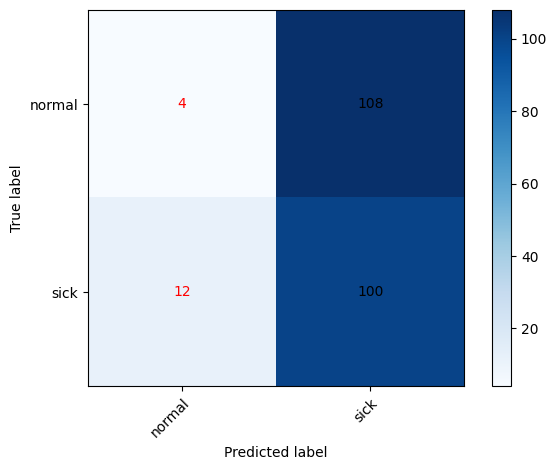

In [50]:
# Compute the confusion matrix
cm = confusion_matrix(y_true2, y_pred2_labels)

# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# Set the classes as labels on the x and y axes
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       xlabel='Predicted label', ylabel='True label')
# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# Loop over the data and add the count values to the plot
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > cm.max() / 2. else "red")
fig.tight_layout()
plt.show()

In [51]:
# Generate the classification report
report = classification_report(y_true2, y_pred2_labels)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.25      0.04      0.06       112
           1       0.48      0.89      0.62       112

    accuracy                           0.46       224
   macro avg       0.37      0.46      0.34       224
weighted avg       0.37      0.46      0.34       224



In [52]:
# Save the report to a text file
with open('classification_report.txt', 'w') as f:
    f.write(report)